## Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore')

## Loading the +25 chemical element geodataframes (1 out of 11 files)

In [2]:
chemI = pd.read_csv("sarig_rs_chem_exp1_25elements.csv")

Checking the info of the first geodataframe

In [3]:
chemI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520335 entries, 0 to 520334
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          520335 non-null  int64  
 1   Unnamed: 0.1        520335 non-null  int64  
 2   SAMPLE_NO           120335 non-null  float64
 3   SAMPLE_SOURCE_CODE  120267 non-null  object 
 4   SAMPLE_SOURCE       120267 non-null  object 
 5   ROCK_GROUP_CODE     74306 non-null   object 
 6   ROCK_GROUP          74306 non-null   object 
 7   LITHO_CODE          74306 non-null   object 
 8   LITHO_CONF          4708 non-null    object 
 9   LITHOLOGY_NAME      74306 non-null   object 
 10  LITHO_MODIFIER      9497 non-null    object 
 11  MAP_SYMBOL          62299 non-null   object 
 12  STRAT_CONF          10815 non-null   object 
 13  STRAT_NAME          62451 non-null   object 
 14  COLLECTED_BY        119631 non-null  object 
 15  COLLECTORS_NUMBER   32750 non-null

## Visual checking of the data for distribution of null (empty) and non-null cells

As a consequence of the first stage of geographical filtering, some spurious empty rows were left in the dataset and must be removed. This is particularly relevant in this first loaded geodataframe, where most of the rows (stacked on the y -axis of the plot below) are indeed empty (no sample number in their record) as indicated by the yellow colour, which signals blank cells, as opposed to purple, which is used to indicate non-null values.

Furthermore, the data scanning provided by the plot below also reveals that some columns are not entirely filled. For instance, "LITHO_CONF", "LITHO_MODIFIER" AND "STRAT_CONF" are mostly lacking data.

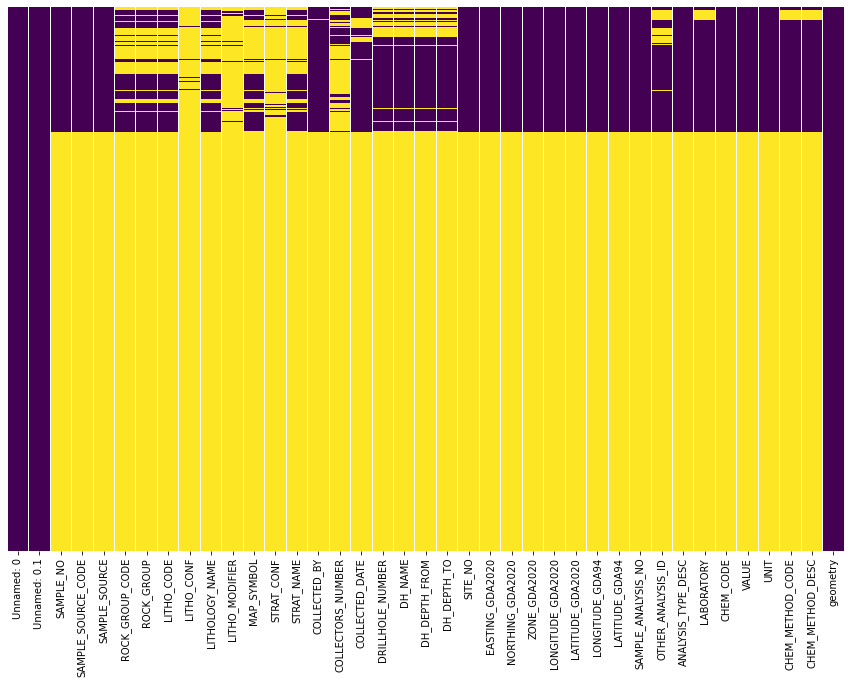

In [4]:
plt.figure(figsize=[15,10])
sns.heatmap(chemI.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Dropping  empty rows

In [5]:
chemI.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

Checking info of the data. Out of the initial 520.335 rows, only 111.141 remain.

In [6]:
chemI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111141 entries, 0 to 120334
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          111141 non-null  int64  
 1   Unnamed: 0.1        111141 non-null  int64  
 2   SAMPLE_NO           111141 non-null  float64
 3   SAMPLE_SOURCE_CODE  111073 non-null  object 
 4   SAMPLE_SOURCE       111073 non-null  object 
 5   ROCK_GROUP_CODE     65216 non-null   object 
 6   ROCK_GROUP          65216 non-null   object 
 7   LITHO_CODE          65216 non-null   object 
 8   LITHO_CONF          4621 non-null    object 
 9   LITHOLOGY_NAME      65216 non-null   object 
 10  LITHO_MODIFIER      6161 non-null    object 
 11  MAP_SYMBOL          53448 non-null   object 
 12  STRAT_CONF          9587 non-null    object 
 13  STRAT_NAME          53448 non-null   object 
 14  COLLECTED_BY        111141 non-null  object 
 15  COLLECTORS_NUMBER   26941 non-null

### Visual checking of the data after removal of empty rows

Reminder:

* purple: non-null cell
* yellow: null cell

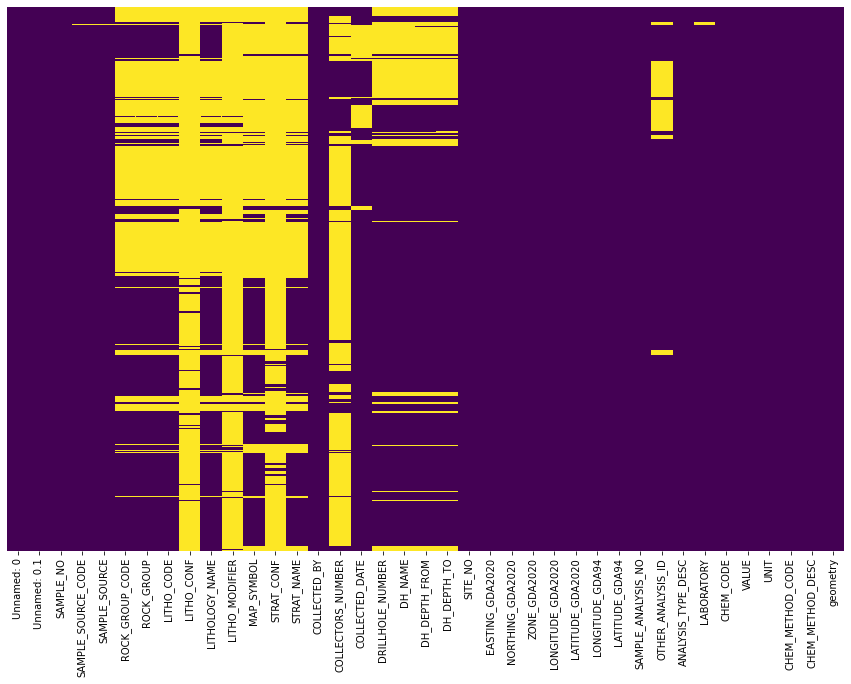

In [7]:
plt.figure(figsize=[15,10])
sns.heatmap(chemI.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Selecting soil samples

Checking the unique values of the column "SAMPLE_SOURCE" and filtering the data based on sample type.

OBSERVATION: THE COMPILED LIST OF SAMPLE TYPES USED FOR FILTERING RESULTS FROM CHECKING THE VALUES OF THE COLUMN "SAMPLE_SOURCE" OF ALL THE 11 GEODATAFRAMES.

In [8]:
chemI['SAMPLE_SOURCE'].unique()

array(['Soil', 'Drill cuttings', 'Rock outcrop / float', 'Drill core',
       nan, 'Vegetation', 'Stream sediment', 'Calcrete',
       'Sawn half drill core', 'Sawn quarter drill core',
       'A full face slice of core', 'Mine rock sample',
       'Drilled interval rock sample, type unspecified',
       'Pulp / powdered rock of known origin, typically a lab return',
       'Analytical standard check sample',
       'Duplicate: a split from an existing sample.',
       'Rock outcrop sample'], dtype=object)

In [9]:
chemI_soil = chemI[(chemI['SAMPLE_SOURCE'] == 'Soil') | (chemI['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemI['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemI['SAMPLE_SOURCE'] == 'Lake floor sediment')]

Checking the info of soil sample dataset.

In [10]:
chemI_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5627 entries, 0 to 29236
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5627 non-null   int64  
 1   Unnamed: 0.1        5627 non-null   int64  
 2   SAMPLE_NO           5627 non-null   float64
 3   SAMPLE_SOURCE_CODE  5627 non-null   object 
 4   SAMPLE_SOURCE       5627 non-null   object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      object 
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        5627 non-null   object 
 15  COLLECTORS_NUMBER   5627 non-null   object 
 16  COLLE

## Filtering by partial digest geochemistry

Checking the unique values of the column "CHEM_METHOD_DESC" and filtering the data based on analytical method.

Essentially, samples processed by fusion or multi-acid digestion were discarded.

OBSERVATION: THE COMPILED LIST OF ANALYTICAL METHODS USED FOR FILTERING RESULTS FROM CHECKING THE VALUES OF THE COLUMN "CHEM_METHOD_DESC" OF ALL THE 11 GEODATAFRAMES.

In [11]:
chemI_soil['CHEM_METHOD_DESC'].unique()

array(['Aqua Regia digest 25g, ICP-MS determination', 'Unknown',
       '0.5g sample, mixed acid digest including HF, ICP-MS determination.',
       'METHOD UNKNOWN'], dtype=object)

In [12]:
chemI_soil = chemI_soil[(chemI_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemI_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemistry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemistry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemistry, AAS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemistry for non-particulate Au, AAS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemistry, ICP- MS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemistry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemistry for non-particulate Au, ICP- MS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

Checking the info of the weakly digested soil sample dataset.

In [13]:
chemI_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1927 entries, 0 to 1926
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1927 non-null   int64  
 1   Unnamed: 0.1        1927 non-null   int64  
 2   SAMPLE_NO           1927 non-null   float64
 3   SAMPLE_SOURCE_CODE  1927 non-null   object 
 4   SAMPLE_SOURCE       1927 non-null   object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      object 
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        1927 non-null   object 
 15  COLLECTORS_NUMBER   1927 non-null   object 
 16  COLLEC

### Visual checking of the data after the previous filtering steps

Reminder:

* purple: non-null cell
* yellow: null cell

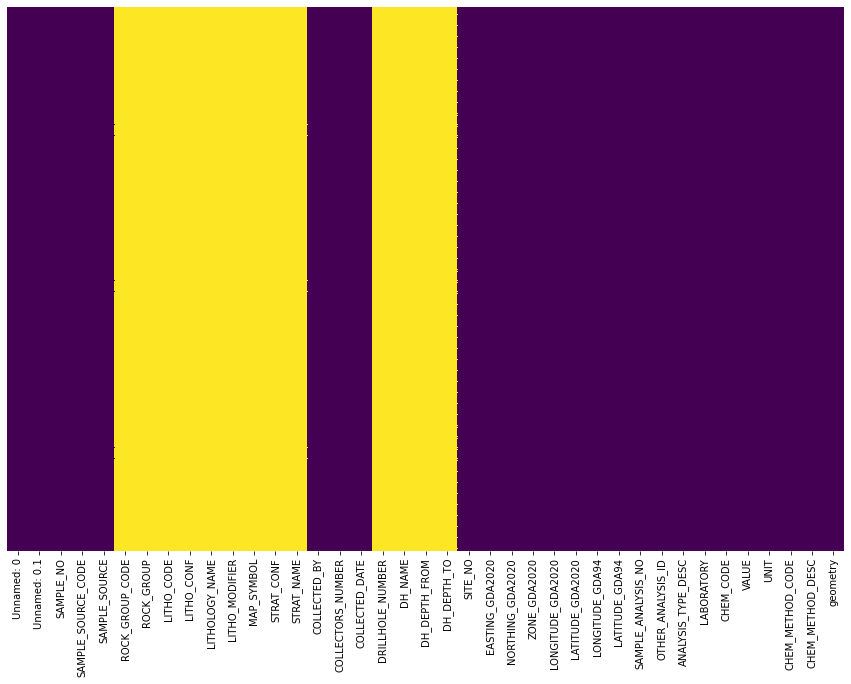

In [14]:
plt.figure(figsize=[15,10])
sns.heatmap(chemI_soil.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Removal of empty and unneccessary columns

Besides the empty columns seen in the plot above, other data are also considered dispensable for the purpose of reducing memory usage and boosting processing speed.

Reminder:

* purple: non-null cell
* yellow: null cell

In [16]:
chemI_soil.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'SAMPLE_SOURCE_CODE', 'ROCK_GROUP_CODE', 'ROCK_GROUP', 'LITHO_CODE',
                    'LITHO_CONF', 'LITHOLOGY_NAME', 'LITHO_MODIFIER', 'MAP_SYMBOL', 'STRAT_CONF', 'STRAT_NAME',
                    'COLLECTED_BY', 'COLLECTORS_NUMBER', 'COLLECTED_DATE', 'DRILLHOLE_NUMBER', 'DH_NAME', 'DH_DEPTH_FROM',
                    'DH_DEPTH_TO', 'LONGITUDE_GDA94', 'LATITUDE_GDA94', 'SAMPLE_ANALYSIS_NO', 'OTHER_ANALYSIS_ID',
                    'ANALYSIS_TYPE_DESC'],axis=1,inplace=True)

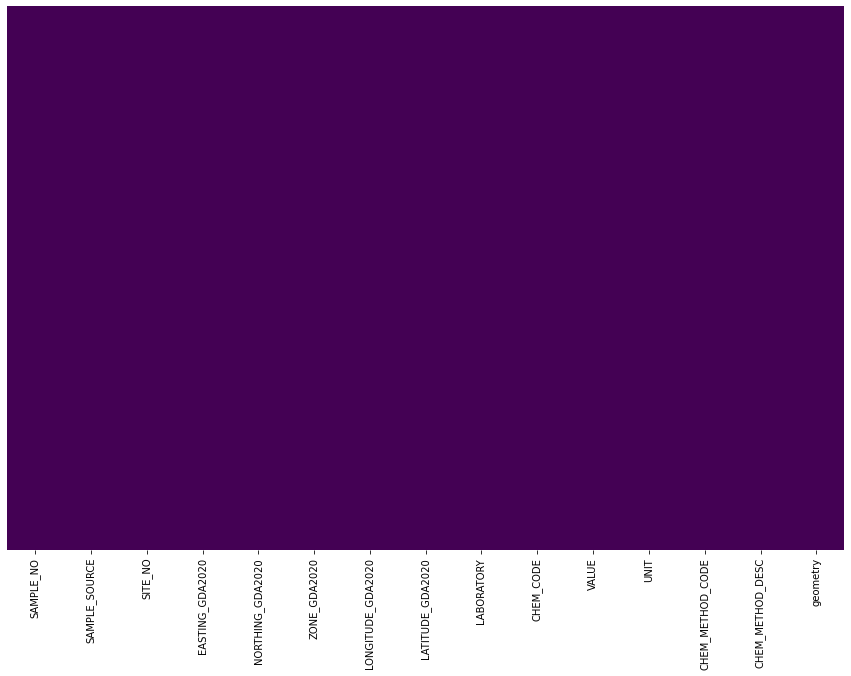

In [17]:
plt.figure(figsize=[15,10])
sns.heatmap(chemI_soil.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Repeating the algorithm in the remaining 10 geodataframes

* Loading the csv file of the geodataframe
* Dropping empty rows
* Filtering by soil samples and partial digest geochemistry
* Dropping the same set of columns as in the first geodataframe

In [18]:
chemII = pd.read_csv("sarig_rs_chem_exp2_25elements.csv")

In [19]:
chemII.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13180 entries, 0 to 13179
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          13180 non-null  int64  
 1   Unnamed: 0.1        13180 non-null  int64  
 2   SAMPLE_NO           13180 non-null  int64  
 3   SAMPLE_SOURCE_CODE  13180 non-null  object 
 4   SAMPLE_SOURCE       13180 non-null  object 
 5   ROCK_GROUP_CODE     125 non-null    object 
 6   ROCK_GROUP          125 non-null    object 
 7   LITHO_CODE          125 non-null    object 
 8   LITHO_CONF          0 non-null      float64
 9   LITHOLOGY_NAME      125 non-null    object 
 10  LITHO_MODIFIER      0 non-null      float64
 11  MAP_SYMBOL          125 non-null    object 
 12  STRAT_CONF          87 non-null     object 
 13  STRAT_NAME          125 non-null    object 
 14  COLLECTED_BY        13180 non-null  object 
 15  COLLECTORS_NUMBER   13180 non-null  object 
 16  COLL

In [20]:
chemII.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [21]:
chemII_soil = chemII[(chemII['SAMPLE_SOURCE'] == 'Soil') | (chemII['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemII['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemII['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [22]:
chemII_soil = chemII_soil[(chemII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemII_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIstry, AAS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIstry for non-particulate Au, AAS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIstry, ICP- MS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIstry for non-particulate Au, ICP- MS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [23]:
chemII_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          0 non-null      int64  
 1   Unnamed: 0.1        0 non-null      int64  
 2   SAMPLE_NO           0 non-null      int64  
 3   SAMPLE_SOURCE_CODE  0 non-null      object 
 4   SAMPLE_SOURCE       0 non-null      object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      float64
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      float64
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        0 non-null      object 
 15  COLLECTORS_NUMBER   0 non-null      object 
 16  COLLECTED_DATE      

In [24]:
chemIII = pd.read_csv("sarig_rs_chem_exp3_25elements.csv")

In [25]:
chemIII.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74152 entries, 0 to 74151
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          74152 non-null  int64  
 1   Unnamed: 0.1        74152 non-null  int64  
 2   SAMPLE_NO           74152 non-null  int64  
 3   SAMPLE_SOURCE_CODE  74152 non-null  object 
 4   SAMPLE_SOURCE       74152 non-null  object 
 5   ROCK_GROUP_CODE     4830 non-null   object 
 6   ROCK_GROUP          4830 non-null   object 
 7   LITHO_CODE          4830 non-null   object 
 8   LITHO_CONF          33 non-null     object 
 9   LITHOLOGY_NAME      4830 non-null   object 
 10  LITHO_MODIFIER      1491 non-null   object 
 11  MAP_SYMBOL          2856 non-null   object 
 12  STRAT_CONF          712 non-null    object 
 13  STRAT_NAME          2856 non-null   object 
 14  COLLECTED_BY        74152 non-null  object 
 15  COLLECTORS_NUMBER   72211 non-null  object 
 16  COLL

In [26]:
chemIII.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [27]:
chemIII_soil = chemIII[(chemIII['SAMPLE_SOURCE'] == 'Soil') | (chemIII['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemIII['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemIII['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [28]:
chemIII_soil = chemIII_soil[(chemIII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIIstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIIstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIIstry, AAS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIIstry for non-particulate Au, AAS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIIstry, ICP- MS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIIstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIIIstry for non-particulate Au, ICP- MS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [29]:
chemIII_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          0 non-null      int64  
 1   Unnamed: 0.1        0 non-null      int64  
 2   SAMPLE_NO           0 non-null      int64  
 3   SAMPLE_SOURCE_CODE  0 non-null      object 
 4   SAMPLE_SOURCE       0 non-null      object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      object 
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        0 non-null      object 
 15  COLLECTORS_NUMBER   0 non-null      object 
 16  COLLECTED_DATE      

In [30]:
chemIV = pd.read_csv("sarig_rs_chem_exp4_25elements.csv")

In [31]:
chemIV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51756 entries, 0 to 51755
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          51756 non-null  int64  
 1   Unnamed: 0.1        51756 non-null  int64  
 2   SAMPLE_NO           51756 non-null  int64  
 3   SAMPLE_SOURCE_CODE  51756 non-null  object 
 4   SAMPLE_SOURCE       51756 non-null  object 
 5   ROCK_GROUP_CODE     13776 non-null  object 
 6   ROCK_GROUP          13776 non-null  object 
 7   LITHO_CODE          13776 non-null  object 
 8   LITHO_CONF          216 non-null    object 
 9   LITHOLOGY_NAME      13776 non-null  object 
 10  LITHO_MODIFIER      0 non-null      float64
 11  MAP_SYMBOL          13734 non-null  object 
 12  STRAT_CONF          413 non-null    object 
 13  STRAT_NAME          13734 non-null  object 
 14  COLLECTED_BY        51756 non-null  object 
 15  COLLECTORS_NUMBER   47177 non-null  object 
 16  COLL

In [32]:
chemIV.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [33]:
chemIV_soil = chemIV[(chemIV['SAMPLE_SOURCE'] == 'Soil') | (chemIV['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemIV['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemIV['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [34]:
chemIV_soil = chemIV_soil[(chemIV_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIVstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIVstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIVstry, AAS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIVstry for non-particulate Au, AAS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIVstry, ICP- MS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIVstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIVstry for non-particulate Au, ICP- MS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemIV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [35]:
chemIV_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          0 non-null      int64  
 1   Unnamed: 0.1        0 non-null      int64  
 2   SAMPLE_NO           0 non-null      int64  
 3   SAMPLE_SOURCE_CODE  0 non-null      object 
 4   SAMPLE_SOURCE       0 non-null      object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      float64
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        0 non-null      object 
 15  COLLECTORS_NUMBER   0 non-null      object 
 16  COLLECTED_DATE      

In [36]:
chemV = pd.read_csv("sarig_rs_chem_exp5_25elements.csv")

In [37]:
chemV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214560 entries, 0 to 2214559
Data columns (total 39 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   Unnamed: 0.1        int64  
 2   SAMPLE_NO           int64  
 3   SAMPLE_SOURCE_CODE  object 
 4   SAMPLE_SOURCE       object 
 5   ROCK_GROUP_CODE     object 
 6   ROCK_GROUP          object 
 7   LITHO_CODE          object 
 8   LITHO_CONF          float64
 9   LITHOLOGY_NAME      object 
 10  LITHO_MODIFIER      object 
 11  MAP_SYMBOL          object 
 12  STRAT_CONF          object 
 13  STRAT_NAME          object 
 14  COLLECTED_BY        object 
 15  COLLECTORS_NUMBER   object 
 16  COLLECTED_DATE      object 
 17  DRILLHOLE_NUMBER    float64
 18  DH_NAME             object 
 19  DH_DEPTH_FROM       float64
 20  DH_DEPTH_TO         float64
 21  SITE_NO             int64  
 22  EASTING_GDA2020     float64
 23  NORTHING_GDA2020    float64
 24  ZONE_GDA2020        int6

In [38]:
chemV.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [39]:
chemV_soil = chemV[(chemV['SAMPLE_SOURCE'] == 'Soil') | (chemV['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemV['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemV['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [40]:
chemV_soil = chemV_soil[(chemV_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemV_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVstry, AAS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVstry for non-particulate Au, AAS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVstry, ICP- MS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVstry for non-particulate Au, ICP- MS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemV_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [41]:
chemV_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          0 non-null      int64  
 1   Unnamed: 0.1        0 non-null      int64  
 2   SAMPLE_NO           0 non-null      int64  
 3   SAMPLE_SOURCE_CODE  0 non-null      object 
 4   SAMPLE_SOURCE       0 non-null      object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      float64
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      object 
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        0 non-null      object 
 15  COLLECTORS_NUMBER   0 non-null      object 
 16  COLLECTED_DATE      

In [42]:
chemVI = pd.read_csv("sarig_rs_chem_exp6_25elements.csv")

In [43]:
chemVI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585993 entries, 0 to 585992
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          585993 non-null  int64  
 1   Unnamed: 0.1        585993 non-null  int64  
 2   SAMPLE_NO           585993 non-null  int64  
 3   SAMPLE_SOURCE_CODE  585993 non-null  object 
 4   SAMPLE_SOURCE       585993 non-null  object 
 5   ROCK_GROUP_CODE     392 non-null     object 
 6   ROCK_GROUP          392 non-null     object 
 7   LITHO_CODE          392 non-null     object 
 8   LITHO_CONF          84 non-null      object 
 9   LITHOLOGY_NAME      392 non-null     object 
 10  LITHO_MODIFIER      0 non-null       float64
 11  MAP_SYMBOL          392 non-null     object 
 12  STRAT_CONF          196 non-null     object 
 13  STRAT_NAME          392 non-null     object 
 14  COLLECTED_BY        585993 non-null  object 
 15  COLLECTORS_NUMBER   585601 non-nul

In [44]:
chemVI.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [45]:
chemVI_soil = chemVI[(chemVI['SAMPLE_SOURCE'] == 'Soil') | (chemVI['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemVI['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemVI['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [46]:
chemVI_soil = chemVI_soil[(chemVI_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIstry, AAS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIstry for non-particulate Au, AAS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIstry, ICP- MS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIstry for non-particulate Au, ICP- MS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemVI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [47]:
chemVI_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          0 non-null      int64  
 1   Unnamed: 0.1        0 non-null      int64  
 2   SAMPLE_NO           0 non-null      int64  
 3   SAMPLE_SOURCE_CODE  0 non-null      object 
 4   SAMPLE_SOURCE       0 non-null      object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      float64
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        0 non-null      object 
 15  COLLECTORS_NUMBER   0 non-null      object 
 16  COLLECTED_DATE      

In [48]:
chemVII = pd.read_csv("sarig_rs_chem_exp7_25elements.csv")

In [49]:
chemVII.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236962 entries, 0 to 1236961
Data columns (total 39 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Unnamed: 0          1236962 non-null  int64  
 1   Unnamed: 0.1        1236962 non-null  int64  
 2   SAMPLE_NO           1236962 non-null  int64  
 3   SAMPLE_SOURCE_CODE  1236962 non-null  object 
 4   SAMPLE_SOURCE       1236962 non-null  object 
 5   ROCK_GROUP_CODE     4707 non-null     object 
 6   ROCK_GROUP          4707 non-null     object 
 7   LITHO_CODE          4707 non-null     object 
 8   LITHO_CONF          179 non-null      object 
 9   LITHOLOGY_NAME      4707 non-null     object 
 10  LITHO_MODIFIER      1208 non-null     object 
 11  MAP_SYMBOL          3884 non-null     object 
 12  STRAT_CONF          1001 non-null     object 
 13  STRAT_NAME          3884 non-null     object 
 14  COLLECTED_BY        1236697 non-null  object 
 15  COLLECTORS_NUMB

In [50]:
chemVII.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [51]:
chemVII_soil = chemVII[(chemVII['SAMPLE_SOURCE'] == 'Soil') | (chemVII['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemVII['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemVII['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [52]:
chemVII_soil = chemVII_soil[(chemVII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIstry, AAS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIstry for non-particulate Au, AAS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIstry, ICP- MS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIstry for non-particulate Au, ICP- MS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemVII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [53]:
chemVII_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488351 entries, 96183 to 662833
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          488351 non-null  int64  
 1   Unnamed: 0.1        488351 non-null  int64  
 2   SAMPLE_NO           488351 non-null  int64  
 3   SAMPLE_SOURCE_CODE  488351 non-null  object 
 4   SAMPLE_SOURCE       488351 non-null  object 
 5   ROCK_GROUP_CODE     0 non-null       object 
 6   ROCK_GROUP          0 non-null       object 
 7   LITHO_CODE          0 non-null       object 
 8   LITHO_CONF          0 non-null       object 
 9   LITHOLOGY_NAME      0 non-null       object 
 10  LITHO_MODIFIER      0 non-null       object 
 11  MAP_SYMBOL          0 non-null       object 
 12  STRAT_CONF          0 non-null       object 
 13  STRAT_NAME          0 non-null       object 
 14  COLLECTED_BY        488351 non-null  object 
 15  COLLECTORS_NUMBER   488351 non

In [54]:
chemVII_soil.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'SAMPLE_SOURCE_CODE', 'ROCK_GROUP_CODE', 'ROCK_GROUP',
                           'LITHO_CODE', 'LITHO_CONF', 'LITHOLOGY_NAME', 'LITHO_MODIFIER', 'MAP_SYMBOL', 'STRAT_CONF',
                           'STRAT_NAME', 'COLLECTED_BY', 'COLLECTORS_NUMBER', 'COLLECTED_DATE', 'DRILLHOLE_NUMBER',
                           'DH_NAME', 'DH_DEPTH_FROM', 'DH_DEPTH_TO', 'LONGITUDE_GDA94', 'LATITUDE_GDA94',
                           'SAMPLE_ANALYSIS_NO', 'OTHER_ANALYSIS_ID', 'ANALYSIS_TYPE_DESC'],axis=1,inplace=True)

In [55]:
chemVIII = pd.read_csv("sarig_rs_chem_exp8_25elements.csv")

In [56]:
chemVIII.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97212 entries, 0 to 97211
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          97212 non-null  int64  
 1   Unnamed: 0.1        97212 non-null  int64  
 2   SAMPLE_NO           97212 non-null  int64  
 3   SAMPLE_SOURCE_CODE  97212 non-null  object 
 4   SAMPLE_SOURCE       97212 non-null  object 
 5   ROCK_GROUP_CODE     2519 non-null   object 
 6   ROCK_GROUP          2519 non-null   object 
 7   LITHO_CODE          2519 non-null   object 
 8   LITHO_CONF          25 non-null     object 
 9   LITHOLOGY_NAME      2519 non-null   object 
 10  LITHO_MODIFIER      793 non-null    object 
 11  MAP_SYMBOL          2356 non-null   object 
 12  STRAT_CONF          779 non-null    object 
 13  STRAT_NAME          2356 non-null   object 
 14  COLLECTED_BY        97004 non-null  object 
 15  COLLECTORS_NUMBER   95130 non-null  object 
 16  COLL

In [57]:
chemVIII.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [58]:
chemVIII_soil = chemVIII[(chemVIII['SAMPLE_SOURCE'] == 'Soil') | (chemVIII['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemVIII['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemVIII['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [59]:
chemVIII_soil = chemVIII_soil[(chemVIII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIIstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIIstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIIstry, AAS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIIstry for non-particulate Au, AAS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIIstry, ICP- MS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIIstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemVIIIstry for non-particulate Au, ICP- MS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemVIII_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [60]:
chemVIII_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7675 entries, 72389 to 97211
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          7675 non-null   int64  
 1   Unnamed: 0.1        7675 non-null   int64  
 2   SAMPLE_NO           7675 non-null   int64  
 3   SAMPLE_SOURCE_CODE  7675 non-null   object 
 4   SAMPLE_SOURCE       7675 non-null   object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      object 
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        7675 non-null   object 
 15  COLLECTORS_NUMBER   7675 non-null   object 
 16  C

In [61]:
chemVIII_soil.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'SAMPLE_SOURCE_CODE', 'ROCK_GROUP_CODE', 'ROCK_GROUP',
                           'LITHO_CODE', 'LITHO_CONF', 'LITHOLOGY_NAME', 'LITHO_MODIFIER', 'MAP_SYMBOL', 'STRAT_CONF',
                           'STRAT_NAME', 'COLLECTED_BY', 'COLLECTORS_NUMBER', 'COLLECTED_DATE', 'DRILLHOLE_NUMBER',
                           'DH_NAME', 'DH_DEPTH_FROM', 'DH_DEPTH_TO', 'LONGITUDE_GDA94', 'LATITUDE_GDA94',
                           'SAMPLE_ANALYSIS_NO', 'OTHER_ANALYSIS_ID', 'ANALYSIS_TYPE_DESC'],axis=1,inplace=True)

In [62]:
chemIX = pd.read_csv("sarig_rs_chem_exp9_25elements.csv")

In [63]:
chemIX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694351 entries, 0 to 694350
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          694351 non-null  int64  
 1   Unnamed: 0.1        694351 non-null  int64  
 2   SAMPLE_NO           694351 non-null  int64  
 3   SAMPLE_SOURCE_CODE  694284 non-null  object 
 4   SAMPLE_SOURCE       694284 non-null  object 
 5   ROCK_GROUP_CODE     9694 non-null    object 
 6   ROCK_GROUP          9694 non-null    object 
 7   LITHO_CODE          9694 non-null    object 
 8   LITHO_CONF          25 non-null      object 
 9   LITHOLOGY_NAME      9694 non-null    object 
 10  LITHO_MODIFIER      4637 non-null    object 
 11  MAP_SYMBOL          8266 non-null    object 
 12  STRAT_CONF          890 non-null     object 
 13  STRAT_NAME          8266 non-null    object 
 14  COLLECTED_BY        694351 non-null  object 
 15  COLLECTORS_NUMBER   689407 non-nul

In [64]:
chemIX.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [65]:
chemIX_soil = chemIX[(chemIX['SAMPLE_SOURCE'] == 'Soil') | (chemIX['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemIX['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemIX['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [66]:
chemIX_soil = chemIX_soil[(chemIX_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIXstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIXstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIXstry, AAS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIXstry for non-particulate Au, AAS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIXstry, ICP- MS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIXstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemIXstry for non-particulate Au, ICP- MS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemIX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [67]:
chemIX_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94228 entries, 0 to 254713
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          94228 non-null  int64  
 1   Unnamed: 0.1        94228 non-null  int64  
 2   SAMPLE_NO           94228 non-null  int64  
 3   SAMPLE_SOURCE_CODE  94228 non-null  object 
 4   SAMPLE_SOURCE       94228 non-null  object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      object 
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        94228 non-null  object 
 15  COLLECTORS_NUMBER   94228 non-null  object 
 16  COL

In [68]:
chemIX_soil.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'SAMPLE_SOURCE_CODE', 'ROCK_GROUP_CODE', 'ROCK_GROUP',
                           'LITHO_CODE', 'LITHO_CONF', 'LITHOLOGY_NAME', 'LITHO_MODIFIER', 'MAP_SYMBOL', 'STRAT_CONF',
                           'STRAT_NAME', 'COLLECTED_BY', 'COLLECTORS_NUMBER', 'COLLECTED_DATE', 'DRILLHOLE_NUMBER',
                           'DH_NAME', 'DH_DEPTH_FROM', 'DH_DEPTH_TO', 'LONGITUDE_GDA94', 'LATITUDE_GDA94',
                           'SAMPLE_ANALYSIS_NO', 'OTHER_ANALYSIS_ID', 'ANALYSIS_TYPE_DESC'],axis=1,inplace=True)

In [69]:
chemX = pd.read_csv("sarig_rs_chem_exp10_25elements.csv")

In [70]:
chemX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387365 entries, 0 to 387364
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          387365 non-null  int64  
 1   Unnamed: 0.1        387365 non-null  int64  
 2   SAMPLE_NO           187365 non-null  float64
 3   SAMPLE_SOURCE_CODE  187365 non-null  object 
 4   SAMPLE_SOURCE       187365 non-null  object 
 5   ROCK_GROUP_CODE     1724 non-null    object 
 6   ROCK_GROUP          1724 non-null    object 
 7   LITHO_CODE          1724 non-null    object 
 8   LITHO_CONF          134 non-null     object 
 9   LITHOLOGY_NAME      1724 non-null    object 
 10  LITHO_MODIFIER      0 non-null       float64
 11  MAP_SYMBOL          1692 non-null    object 
 12  STRAT_CONF          352 non-null     object 
 13  STRAT_NAME          1692 non-null    object 
 14  COLLECTED_BY        187365 non-null  object 
 15  COLLECTORS_NUMBER   183239 non-nul

In [71]:
chemX.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [72]:
chemX_soil = chemX[(chemX['SAMPLE_SOURCE'] == 'Soil') | (chemX['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemX['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemX['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [73]:
chemX_soil = chemX_soil[(chemX_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemX_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXstry, AAS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXstry for non-particulate Au, AAS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXstry, ICP- MS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXstry for non-particulate Au, ICP- MS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemX_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [74]:
chemX_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66745 entries, 208310 to 282070
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          66745 non-null  int64  
 1   Unnamed: 0.1        66745 non-null  int64  
 2   SAMPLE_NO           66745 non-null  float64
 3   SAMPLE_SOURCE_CODE  66745 non-null  object 
 4   SAMPLE_SOURCE       66745 non-null  object 
 5   ROCK_GROUP_CODE     0 non-null      object 
 6   ROCK_GROUP          0 non-null      object 
 7   LITHO_CODE          0 non-null      object 
 8   LITHO_CONF          0 non-null      object 
 9   LITHOLOGY_NAME      0 non-null      object 
 10  LITHO_MODIFIER      0 non-null      float64
 11  MAP_SYMBOL          0 non-null      object 
 12  STRAT_CONF          0 non-null      object 
 13  STRAT_NAME          0 non-null      object 
 14  COLLECTED_BY        66745 non-null  object 
 15  COLLECTORS_NUMBER   66745 non-null  object 
 16

In [75]:
chemX_soil.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'SAMPLE_SOURCE_CODE', 'ROCK_GROUP_CODE', 'ROCK_GROUP',
                           'LITHO_CODE', 'LITHO_CONF', 'LITHOLOGY_NAME', 'LITHO_MODIFIER', 'MAP_SYMBOL', 'STRAT_CONF',
                           'STRAT_NAME', 'COLLECTED_BY', 'COLLECTORS_NUMBER', 'COLLECTED_DATE', 'DRILLHOLE_NUMBER',
                           'DH_NAME', 'DH_DEPTH_FROM', 'DH_DEPTH_TO', 'LONGITUDE_GDA94', 'LATITUDE_GDA94',
                           'SAMPLE_ANALYSIS_NO', 'OTHER_ANALYSIS_ID', 'ANALYSIS_TYPE_DESC'],axis=1,inplace=True)

In [76]:
chemXI = pd.read_csv("sarig_rs_chem_exp11_25elements.csv")

In [77]:
chemXI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187500 entries, 0 to 187499
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          187500 non-null  int64  
 1   Unnamed: 0.1        187500 non-null  int64  
 2   SAMPLE_NO           187500 non-null  int64  
 3   SAMPLE_SOURCE_CODE  187500 non-null  object 
 4   SAMPLE_SOURCE       187500 non-null  object 
 5   ROCK_GROUP_CODE     0 non-null       float64
 6   ROCK_GROUP          0 non-null       float64
 7   LITHO_CODE          0 non-null       float64
 8   LITHO_CONF          0 non-null       float64
 9   LITHOLOGY_NAME      0 non-null       float64
 10  LITHO_MODIFIER      0 non-null       float64
 11  MAP_SYMBOL          0 non-null       float64
 12  STRAT_CONF          0 non-null       float64
 13  STRAT_NAME          0 non-null       float64
 14  COLLECTED_BY        187500 non-null  object 
 15  COLLECTORS_NUMBER   187500 non-nul

In [78]:
chemXI.dropna(subset=['CHEM_CODE','CHEM_METHOD_CODE'],inplace=True)

In [79]:
chemXI_soil = chemXI[(chemXI['SAMPLE_SOURCE'] == 'Soil') | (chemXI['SAMPLE_SOURCE'] == 'Calcrete') | 
     (chemXI['SAMPLE_SOURCE'] == 'Auger sample from near surface') | (chemXI['SAMPLE_SOURCE'] == 'Lake floor sediment')]

In [80]:
chemXI_soil = chemXI_soil[(chemXI_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions') | 
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'MMI - mobile metal ions (FGFLAH)') | 
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination. (Numeric suffix denotes proprietary solvent method).') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXIstry. A very weak acid based digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXIstry. Weak acid EDTA digest designed for Cu, Pb, Zn. Ideal for base metals in alkaline soils.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXIstry, AAS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXIstry for non-particulate Au, AAS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Mobile Metal Ions - partial leach technology, ICP-MS follow-up') | 
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Partial leach (MMI), ICP-MS determination (AAS for Fe, Mn). (Numeric suffix denotes proprietary solvent method).') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXIstry, ICP- MS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXIstry. Very weak acid digest designed to de-sorb base metals and other elements in non-alkaline soils.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Terra Leach partial digest geochemXIstry for non-particulate Au, ICP- MS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Inductively Coupled Plasma Optical Emission Spectrometry determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-MS determination') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, Atomic Absorption Spectrometry') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Base metals: Aqua regia digest, AAS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; carbon rod') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia; AAS, OR 2g; perchloric acid; AAS') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, AAS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '30g; aqua regia digest, carbon rod collection, AAS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest 25g, ICP-OES determination') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '30g, aqua regia, carbon rod') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '25g sample; roasted, aqua regia digested, extracted into 336/DIBK, backwashed with dilute nitric acid, analysed by AAS') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '30g aqua regia; AAS finish') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest for base metals, AAS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Low level Au: Aqua regia digest, DIBK extraction, carbon rod AAS determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '1 gm mini Aqua Regia digest ij test tubes, Enhanced ICP-OES determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Gold analysis by aqua regia extraction with ICP-MS finish.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '10g sample, Aqua Regia digest, combination ICP-MS and ICP-OES determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Calcrete samples: Total aqua regia digest, ICP-OES finish.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '25g nominal sample weight, trace level Au, aqua regia digest with AAS or ICP-MS determinations.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '30g sample, ultratrace by ICP-MS analysis after aqua regia digestion.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '0.5g sample, Aqua Regia leach, combination ICP-MS and ICP-AES determination.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Partial digest technique using a dilute HCl partial leach.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == '20gm sample, aqua regia digest, ICP-OES / ICP-MS determination depending on analyte. ICP-OES: As Ca Cr Cu Fe Mg Mn Ni P V Zn. ICP-MS: Ag Au Bi Cd Co Ga Mo Pb Pt Sb Se Te Th Tl U W.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua Regia digest, AAS') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digestion, flame AAS.') |
                      (chemXI_soil['CHEM_METHOD_DESC'] == 'Aqua regia digest Bulk Leach Extractable Gold, Inductively Coupled Plasma Mass Spectrometry.')]

In [81]:
chemXI_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          0 non-null      int64  
 1   Unnamed: 0.1        0 non-null      int64  
 2   SAMPLE_NO           0 non-null      int64  
 3   SAMPLE_SOURCE_CODE  0 non-null      object 
 4   SAMPLE_SOURCE       0 non-null      object 
 5   ROCK_GROUP_CODE     0 non-null      float64
 6   ROCK_GROUP          0 non-null      float64
 7   LITHO_CODE          0 non-null      float64
 8   LITHO_CONF          0 non-null      float64
 9   LITHOLOGY_NAME      0 non-null      float64
 10  LITHO_MODIFIER      0 non-null      float64
 11  MAP_SYMBOL          0 non-null      float64
 12  STRAT_CONF          0 non-null      float64
 13  STRAT_NAME          0 non-null      float64
 14  COLLECTED_BY        0 non-null      object 
 15  COLLECTORS_NUMBER   0 non-null      object 
 16  COLLECTED_DATE      

## Concatenating the filtered geodataframes and saving as csv

In [82]:
chem_soil = pd.concat([chemI_soil,chemVII_soil,chemVIII_soil,chemIX_soil,chemX_soil])

In [83]:
chem_soil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658926 entries, 0 to 282070
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SAMPLE_NO          658926 non-null  float64
 1   SAMPLE_SOURCE      658926 non-null  object 
 2   SITE_NO            658926 non-null  float64
 3   EASTING_GDA2020    658926 non-null  float64
 4   NORTHING_GDA2020   658926 non-null  float64
 5   ZONE_GDA2020       658926 non-null  float64
 6   LONGITUDE_GDA2020  658926 non-null  float64
 7   LATITUDE_GDA2020   658926 non-null  float64
 8   LABORATORY         658926 non-null  object 
 9   CHEM_CODE          658926 non-null  object 
 10  VALUE              658926 non-null  object 
 11  UNIT               658926 non-null  object 
 12  CHEM_METHOD_CODE   658926 non-null  object 
 13  CHEM_METHOD_DESC   658926 non-null  object 
 14  geometry           658926 non-null  object 
dtypes: float64(7), object(8)
memory usage: 80.4+ MB


In [84]:
chem_soil.to_csv("sarig_rs_chem_exp_25elements_soil.csv")